In [1]:
import os, gc
import glob

from tqdm.notebook import tqdm
import pandas as pd
import numpy as np

from joblib import Parallel, delayed
from sklearn import preprocessing, model_selection

import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

%matplotlib inline

In [2]:
path_root = "./"
path_data = "./"

path_submissions = "./"

target_name = 'target'

In [3]:
train = pd.read_csv(os.path.join(path_data, 'train.csv'))

In [4]:
test = pd.read_csv(os.path.join(path_data,'test.csv'))

In [5]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

def count_unique(series):
    return len(np.unique(series))

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def rmspe(y_true, y_pred):
    return (np.sqrt(np.mean(np.square((y_true - y_pred)/y_true))))

def aggressor_side(series):
    return np.sign(series.diff())

def dollar_volume(df):
    return np.array(df['price'])*np.array(df['size'])

def signed_dollar_volume(df):
    side = aggressor_side(df)
    return np.array(df['dollar_volume'])*side

def kyle_lambda(df):
    diff = df['price'].diff().fillna(0)
    diff_sign = diff.apply(np.sign)
    diff_sign.replace(0,method='pad',inplace=True)
    signed_volume = df['size'] * diff_sign
#     print((diff / signed_volume).rolling(window=1).mean())
    return np.array((diff / signed_volume).rolling(window=1).mean())

def hasbrouck_lambda(log_ret, dollar_volume):
    log_ret_sign = log_ret.apply(np.sign).replace(0,method='pad')
    signed_dollar_volume_sqrt = np.sqrt(dollar_volume) * log_ret_sign
    
    return np.array((log_ret/signed_dollar_volume_sqrt).rolling(window=1).mean())

def vpin(volume, signed_buy_volume, window = 1):
    signed_sell_volume = volume - signed_buy_volume
    volume_imb = abs(signed_buy_volume - signed_sell_volume)
    return volume_imb.rolling(window=window).mean()/volume




In [6]:
def trade_preprocessor(file_path):
    df = pd.read_parquet(file_path)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    
    df['side'] = np.sign(df['price'].diff())
    df['dollar_volume'] = df['price'] * df['size']
    df['signed_dollar_volume'] = df['dollar_volume'] * df['side']
    df['kyles'] = kyle_lambda(df)
    df['hasb'] = hasbrouck_lambda(df['log_return'],df['dollar_volume'])
    
    agg_dict = {
        'log_return':[realized_volatility],
        'size':[np.sum],
        'order_count':[np.mean],
        'dollar_volume':[np.sum],
        'signed_dollar_volume':[np.sum],
        'kyles':[np.mean],
        'hasb':[np.mean],
    }
    
    df_feature = df.groupby('time_id').agg(agg_dict)
    
    df_feature = df_feature.reset_index()
    df_feature.columns = ['_'.join(col) for col in df_feature.columns]
    
    df_feature = df_feature.add_prefix('trade_')
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature = df_feature.drop(['trade_time_id_'],axis=1)
    
    return df_feature

def book_preprocessor(file_path):
    df_book = pd.read_parquet(file_path)
    df_book['wap1'] = (df_book['bid_price1'] * df_book['ask_size1'] +
                                    df_book['ask_price1'] * df_book['bid_size1']) / (df_book['bid_size1'] + df_book['ask_size1'])
    df_book['wap2'] = (df_book['bid_price2'] * df_book['ask_size2'] +
                                    df_book['ask_price2'] * df_book['bid_size2']) / (df_book['bid_size2'] + df_book['ask_size2'])
    
    df_book['log_return1'] = df_book.groupby(by = ['time_id'])['wap1'].apply(log_return).fillna(0)
    df_book['log_return2'] = df_book.groupby(by = ['time_id'])['wap2'].apply(log_return).fillna(0)
    df_book['volume'] = (df_book['ask_size1'] + df_book['ask_size2']) + (df_book['bid_size1'] + df_book['bid_size2'])
    df_book['volume_imbalance'] = (df_book['ask_size1'] + df_book['ask_size2']) - (df_book['bid_size1'] + df_book['bid_size1'])
    
    agg_dict = {
        'log_return1':[realized_volatility],
        'log_return2':[realized_volatility],
        'volume':[np.sum],
        'volume_imbalance':[np.sum],
    }
    
    df_book = df_book.groupby(['time_id']).agg(agg_dict).reset_index()
    df_book.columns = ['_'.join(col) for col in df_book.columns]
    stock_id = file_path.split('=')[1]
    df_book['row_id'] = df_book['time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_book = df_book.drop(['time_id_'],axis=1)
    
    return df_book

In [7]:
def get_stock_data(stock_ids,training=True):
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if training:
            dataType = 'train'
            file_path_book = os.path.join(path_data, 'book_{}.parquet/stock_id={}'.format(dataType, stock_id))
            file_path_trade = os.path.join(path_data,'trade_{}.parquet/stock_id={}'.format(dataType, stock_id))
        else:
            dataType = 'test'
            file_path_book = os.path.join(path_data, 'book_{}.parquet/stock_id={}'.format(dataType, stock_id))
            file_path_trade = os.path.join(path_data,'trade_{}.parquet/stock_id={}'.format(dataType, stock_id))
            
        df_tmp = pd.merge(book_preprocessor(file_path_book),trade_preprocessor(file_path_trade),on='row_id',how='left')
        
        
        return pd.concat([df,df_tmp])
    
    
    df = Parallel(n_jobs=-1,verbose=1)(
            delayed(for_joblib)(stock_id) for stock_id in stock_ids
        )
            
        
    df = pd.concat(df,ignore_index=True)
    
    return df

In [8]:
df_train = pd.read_csv('./processed_train.csv',index_col=0)

In [9]:
test_ids = test.stock_id.unique()

In [10]:
%%time
df_test = get_stock_data(test_ids, training=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Wall time: 1.03 s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


In [11]:
df_test = test.merge(df_test,on=['row_id'],how='left')

In [12]:
df_train['stock_id'] = df_train['row_id'].apply(lambda x:x.split('-')[0])
df_test['stock_id'] = df_test['row_id'].apply(lambda x:x.split('-')[0])


stock_id_target_mean = df_train.groupby('stock_id')['target'].mean()
df_test['stock_id_target_enc'] = df_test['stock_id'].map(stock_id_target_mean)



In [13]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10,shuffle=True,random_state=729201)

tmp = np.repeat(np.nan,df_train.shape[0])

for idx1, idx2 in kf.split(df_train):
    target_mean = df_train.iloc[idx1].groupby('stock_id')['target'].mean()
    tmp[idx2] = df_train['stock_id'].iloc[idx2].map(target_mean)
    
df_train['stock_id_target_enc'] = tmp

In [14]:
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# modified code for group gaps; source
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [15]:
df_train['stock_id'] = df_train['stock_id'].astype(int)
df_test['stock_id'] = df_test['stock_id'].astype(int)

In [16]:
df_train['trade_order_count_mean'] = df_train['trade_order_count_mean'].astype('float')

In [17]:
X = df_train.drop(['row_id','target'],axis=1)
y = df_train['target']

In [19]:
groupedKFold = PurgedGroupTimeSeriesSplit(n_splits=4, group_gap=12)
split = list(groupedKFold.split(df_train['target'],groups=df_train['stock_id'].values))

In [19]:
test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [29]:
df_test = df_test.replace([np.inf,-np.inf],np.nan).fillna(method='ffill')

In [35]:
model_name = 'xgb_reg_'

models = dict()

xgb_reg_params = {
    'tree_method':'gpu_hist',
    'learning_rate': .1,
    'max_depth': 15,
    'min_child_weight': 6,
    'n_estimators': 350,
    'subsample': 0.8,
    'colsample_bytree': 0.6000000000000001
} 

xgb_fit_params = {
    'eval_metric':'rmse',
    'early_stopping_rounds': 10,
    'sample_weight_eval_set':[],
    'sample_weight':np.zeros(0),
    'verbose':False
}

xgb_params = {}
xgb_params['reg_params'] = xgb_reg_params
xgb_params['fit_params'] = xgb_fit_params

loss = 0.0

for _fold, (tr,te) in enumerate(split):

    print(f'Fold: {_fold}')
    
    trainSetX = X.loc[tr]
    trainSetY = y.loc[tr]
    
    valSetX = X.loc[te]
    valSetY = y.loc[te]
    
    
    weights = (1/np.square(trainSetY))
    valWeights = (1/np.square(valSetY))
    
    xgb_params['fit_params']['sample_weight_eval_set'] = [weights,valWeights]
    xgb_params['fit_params']['sample_weight'] = weights
    
    model = xgb.XGBRegressor(**xgb_params['reg_params'])
    
    model.fit(trainSetX,trainSetY,
             eval_set=[(trainSetX,trainSetY),(valSetX,valSetY)],
             **xgb_params['fit_params'])
    
    pred = model.predict(trainSetX)
    
    loss = (rmspe(trainSetY, pred))
    
    models[model_name+str(_fold)] = dict()
    models[model_name+str(_fold)]['model'] = model
    models[model_name+str(_fold)]['loss'] = loss
    
    print(f'Loss: {loss}')
    
    
    
    

Fold: 0
Loss: 0.049632111159232134
Fold: 1
Loss: 0.10317700195693687
Fold: 2
Loss: 0.12815857606911824
Fold: 3
Loss: 0.1419579124873462


In [42]:
for model_name in models:
        models[model_name]['model'].save_model(model_name+'.json')

In [30]:
y_pred = df_test[['row_id']]
X_test = df_test.drop(['time_id','row_id'],axis=1)

In [31]:
X_test['trade_order_count_mean'] = X_test['trade_order_count_mean'].astype(float)

In [32]:
target = np.zeros(len(X_test))

In [39]:
# #load models
# models = []
# for fold in range(0,4):
#     model_name = 'xgb_reg_{}.json'.format(fold)
#     reg = xgb.XGBRegressor()
#     reg.load_model(model_name)
#     models.append(reg)

In [44]:
# for model in models:
#     pred = model.predict(X_test)
    
#     target += pred/4

In [49]:
for model_name in models:
    pred = models[model_name]['model'].predict(X_test[valSetX.columns])
    
    target += pred/4

In [45]:
y_pred = y_pred.assign(target=target)

In [46]:
y_pred

,row_id,target
0,0-4,0.002099
1,0-32,0.002099
2,0-34,0.002099


In [48]:
y_pred.to_csv('submission.csv')

In [54]:
importance = []
for model_name in models:
    feat_imp = models[model_name]['model'].feature_importances_
    importance.append(feat_imp)

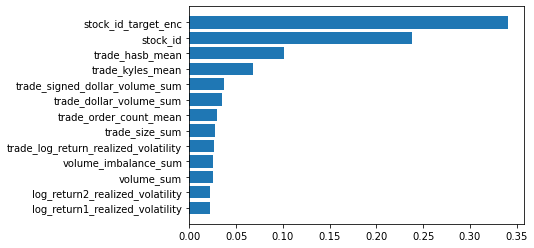

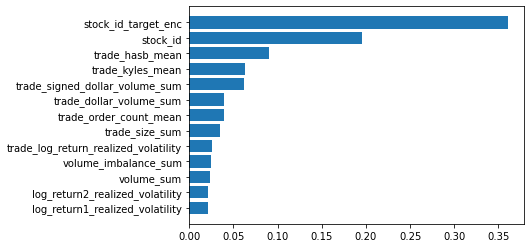

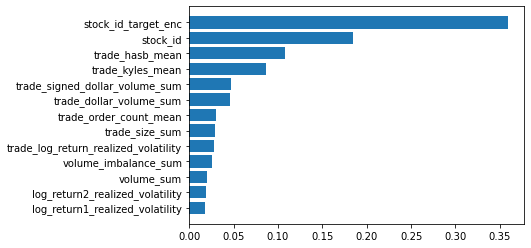

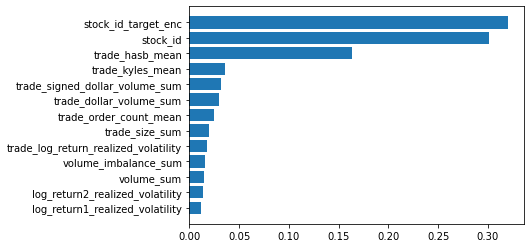

In [58]:
for imp in importance:
    sorted_idx = imp.argsort()
    plt.figure()
    plt.barh(valSetX.columns,imp[sorted_idx])
    plt.show()